# Modelling for VMC 

Below, we will introduce a couple of models. The first is Dense Autoencoders, these will be followed by GANs. We will fix a structure/architecture details for these in the next few days, then do our comparisons with these details, for one of the subsections of the projects.

## AutoEncoder Basic Structure

In [37]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Model

import keras
from keras import layers

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import fashion_mnist, cifar10

In [38]:
class_labels = { 0: "T-shirt/top", 
                1: "Trouser",
                2: "Pullover",
                3: "Dress",
                4: "Coat",
                5: "Sandal",
                6: "Shirt",
                7: "Sneaker",
                8: "Bag",
                9: "Ankle-boot" 
            }

In [39]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train.shape, x_test.shape, y_train.shape, y_test.shape 

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

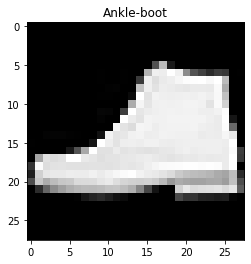

In [40]:
# show a random image from the training set
pixels, class_label = x_train[42], class_labels[y_train[42]]
plt.title(str(class_label))
plt.imshow(pixels, cmap='gray')
plt.show()

In [41]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print(x_train.shape, x_test.shape) 

(60000, 28, 28) (10000, 28, 28)


In [42]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [43]:
# First Encoder model

def Encoder(input_img):
    encoded = layers.Dense(128, activation='relu')(input_img)
    encoded = layers.Dense(64, activation='relu')(encoded)
    encoded = layers.Dense(32, activation='relu')(encoded)
    return encoded

In [44]:
# First Decoder model

def Decoder(encoded):
    decoded = layers.Dense(64, activation='relu')(encoded)
    decoded = layers.Dense(128, activation='relu')(decoded)
    decoded = layers.Dense(1, activation='sigmoid')(decoded)
    return decoded

In [45]:
# First Autoencoder model

input = Input(shape=(28, 28, 1))
encoder = Encoder(input)
decoder = Decoder(encoder)
autoencoder = Model(input, decoder)
autoencoder.compile(optimizer = "adam", loss = "binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 dense_10 (Dense)            (None, 28, 28, 128)       256       
                                                                 
 dense_11 (Dense)            (None, 28, 28, 64)        8256      
                                                                 
 dense_12 (Dense)            (None, 28, 28, 32)        2080      
                                                                 
 dense_13 (Dense)            (None, 28, 28, 64)        2112      
                                                                 
 dense_14 (Dense)            (None, 28, 28, 128)       8320      
                                                                 
 dense_15 (Dense)            (None, 28, 28, 1)         129   

In [46]:
autoencoder.fit(x_train, x_train, epochs = 1, batch_size = 64, validation_data = (x_test, x_test)) 

938/938 [==============================] - 112s 118ms/step - loss: 0.2641 - val_loss: 0.2431


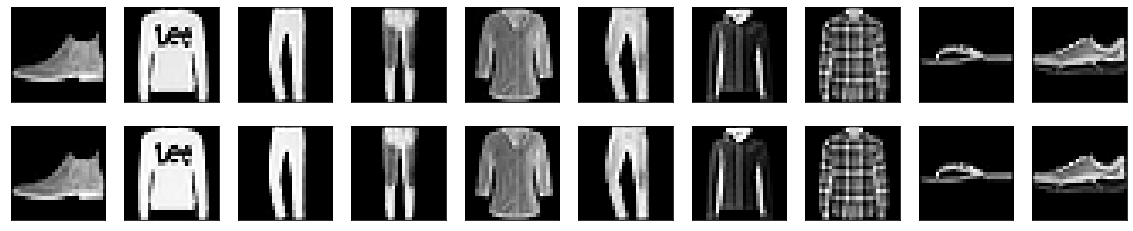

In [47]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
 plt.gray()
 ax = plt.subplot(2, n, i+1)
 plt.imshow(x_test[i].reshape(28, 28))
 ax.get_xaxis().set_visible(False)
 ax.get_yaxis().set_visible(False)
 
 ax = plt.subplot(2, n, i +1+n)
 plt.imshow(decoded_imgs[i].reshape(28, 28))
 ax.get_xaxis().set_visible(False)
 ax.get_yaxis().set_visible(False)
plt.show() 

## Generative Adversarial Nets' Basic Structure

In [535]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd
from auxiliaries.class_struct import GAN 

In [254]:

#params
image_size = (28,28,1)
n_train =int(60000/128)
n_test = int(10000/128)
N_Z = 64

# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()
# split dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype(
    "float32"
) / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

# batching datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(60000)
    .batch(128)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(10000)
    .batch(128)
)

In [255]:

generator = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

discriminator = [
    tf.keras.layers.InputLayer(input_shape=image_size),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation=None),
]

In [256]:
def build_mode(generator,discriminator,N_Z=28):
    # optimizers
    gen_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
    disc_optimizer = tf.keras.optimizers.RMSprop(0.005)# train the model
    # model
    model = GAN(
        gen = generator,
        disc = discriminator,
        gen_optimizer = gen_optimizer,
        disc_optimizer = disc_optimizer,
        n_Z = N_Z)

    return model

model=build_mode(generator, discriminator)

In [257]:
# saving training stats
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])
# training loop
n_epochs = 1
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(n_train), train_dataset), total=n_train
    ):
        model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(n_train), test_dataset), total=n_train
    ):
        loss.append(model.compute_loss(test_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)

    #prints
    print(
        "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )
    



 17%|█▋        | 79/468 [00:06<00:31, 12.21it/s]

Epoch: 0 | disc_loss: 1.1647601127624512 | gen_loss: 0.6394561529159546


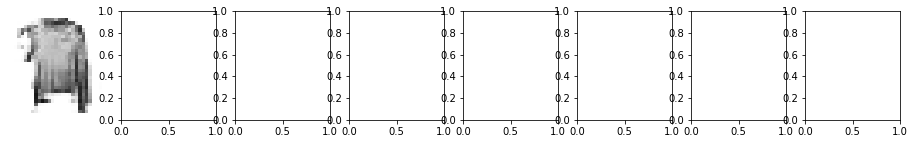

In [53]:
samples = model.generate(tf.random.normal(shape=(128, N_Z)))
nex=8
zm=2
fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
for axi in range(nex):
    axs[axi].matshow(
                samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
            )
    axs[axi].axis('off')
    plt.show()